🎯 **TALLER 1: SERIES DE TIEMPO**

📅 **Fecha:** 2025

👤 **Equipo:** [Hector Hernan Betancourt Lopez - Marcela Fajardo Bermúdez]

#### * Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

## **1. Importación de librerias**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


## **2. Carga de datos y vista rápida**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_excel("/content/drive/MyDrive/Maestría_ciencia_de_datos/Fundamentos_Analitica/S7/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head(3)

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120


(222, 4)


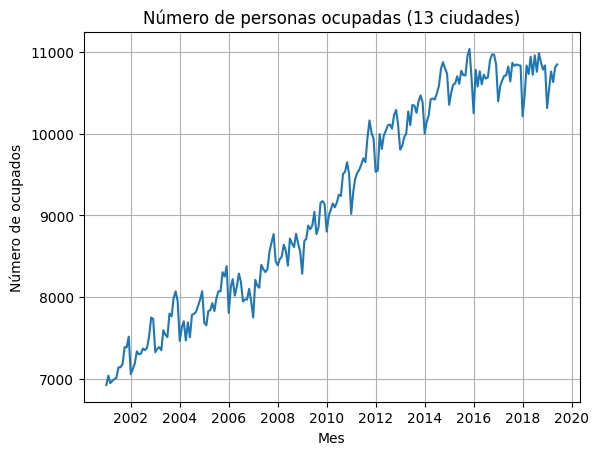

In [4]:
# Dimensiones del dataframe
print(data.shape)

# Graficando los datos
plt.title("Número de personas ocupadas (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Número de ocupados")
plt.plot(data[['Ocupados']])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

Se procede a descomponer la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**.

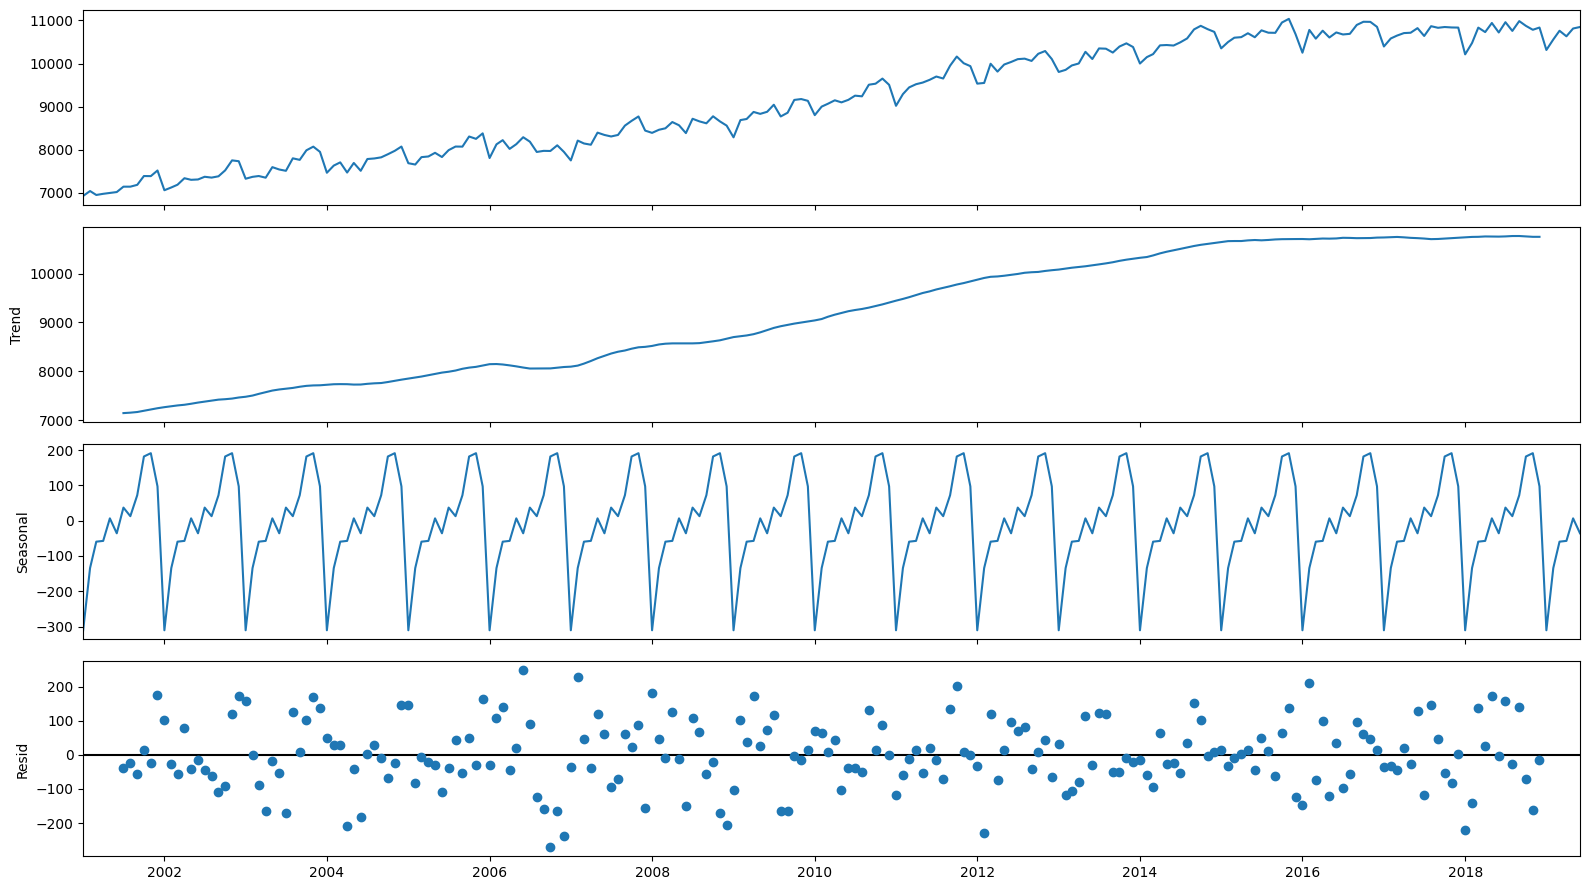

In [5]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [6]:
td_componentes.seasonal
# td_componentes.trend
# td_componentes.resid

,seasonal
mes,
2001-01-01,-310.570069
2001-02-01,-134.331549
2001-03-01,-59.585841
2001-04-01,-57.385905
2001-05-01,6.435912
...,...
2019-02-01,-134.331549
2019-03-01,-59.585841
2019-04-01,-57.385905


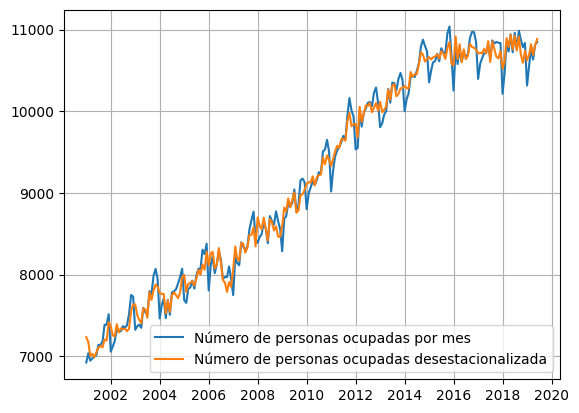

In [7]:
td_desestacionalizada = data['Ocupados']-td_componentes.seasonal

plt.plot(data[['Ocupados']],label="Número de personas ocupadas por mes")
plt.plot(td_desestacionalizada,label="Número de personas ocupadas desestacionalizada")
plt.legend()
plt.grid()
plt.show()


### **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

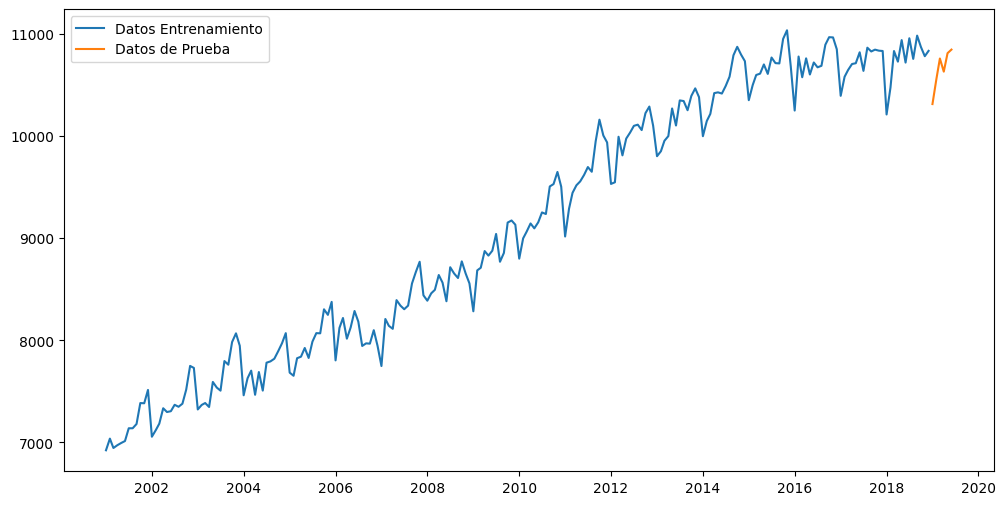

In [8]:
train_len = 216
h = 6
train_td = data[['Ocupados']][:train_len]
test_td = data[['Ocupados']][train_len:train_len+h]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [9]:
train_td

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338


In [10]:
test_td

,Ocupados
mes,
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028
2019-05-01,10813.000
2019-06-01,10848.000


## **4.1 Promedio movil**

In [11]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()
ma_6= train_td.rolling(6,min_periods=2).mean()

In [12]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()
ma_6= train_td.shift().rolling(6,min_periods=2).mean()

In [13]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [14]:
ma_2_f= fore_ma(train_td,2,6)
ma_3_f= fore_ma(train_td,3,6)
ma_4_f= fore_ma(train_td,4,6)
ma_5_f= fore_ma(train_td,5,6)
ma_6_f= fore_ma(train_td,6,6)

In [15]:
test_td

,Ocupados
mes,
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028
2019-05-01,10813.000
2019-06-01,10848.000


In [16]:
ma_2_f

,Ocupados
mes,
2019-01-01,10809.348500
2019-02-01,10822.373250
2019-03-01,10815.860875
2019-04-01,10819.117063
2019-05-01,10817.488969
2019-06-01,10818.303016


In [17]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_td,ma_6_f ))

In [18]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5, rmse_ma_6)

242.8347290019203 250.36984465630144 270.6203851653251 266.5247179311155 272.83744069293607


* **Nota:**

El menor error corresponde al modelo de promedio móvil con ventana de 2 meses(rmse_ma_2), ya que significa que el pronóstico tiene, en promedio, menos error respecto a los datos reales del periodo de prueba

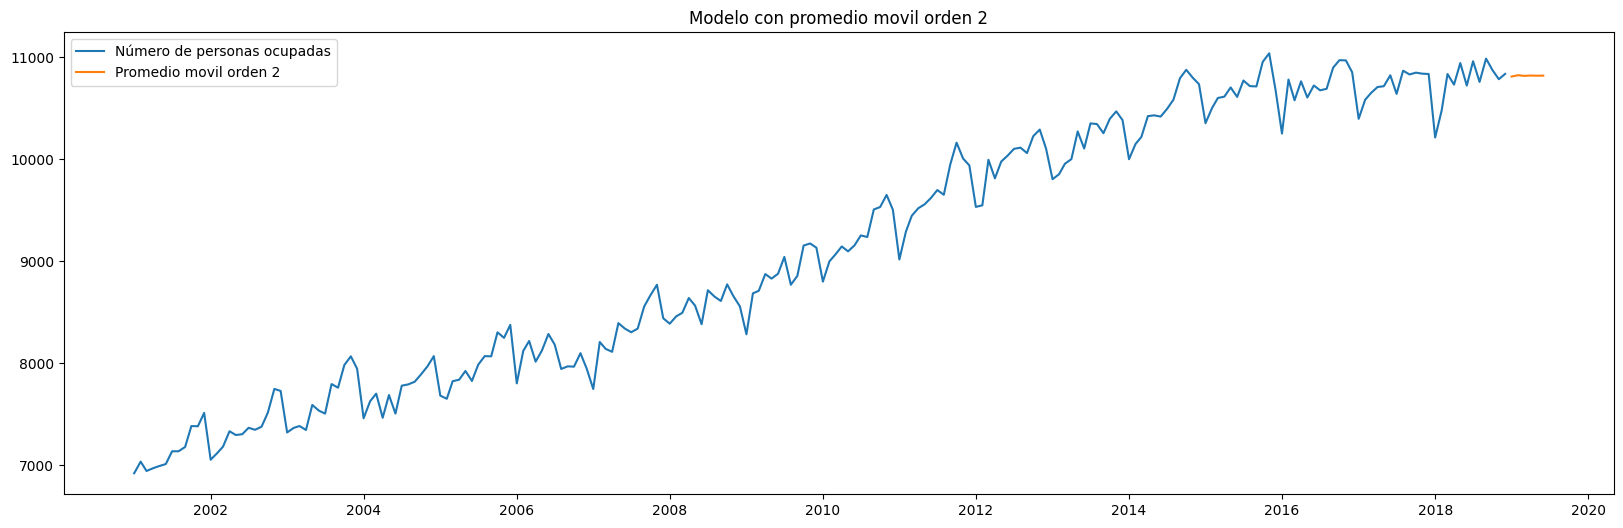

In [19]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Número de personas ocupadas")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend()
plt.title('Modelo con promedio movil orden 2')
plt.show()

## **4.2 Suavizacion Exponencial Simple**

In [20]:
errors = ["add", "mul"]

results = {}

for error_type in errors:
    ets_model = ETSModel(endog=train_td['Ocupados'], error=error_type)
    ets_result = ets_model.fit()

    point_forecast = ets_result.forecast(6)

    ci = ets_result.get_prediction(start=point_forecast.index[0], end=point_forecast.index[-1])

    conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
    limits = ci.predicted_mean

    preds = pd.concat([limits, conf_forecast], axis=1)
    preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

    print(f"Resultados para error '{error_type}':")
    print("-"*40)
    print(preds)
    print("-"*40)
    print(f"Alpha: {ets_result.params[0]}")
    print("-"*40)
    rmse = np.sqrt(mean_squared_error(test_td,point_forecast))
    print(f"RMSE: {rmse}")
    print("-"*40)


    results[error_type] = preds

Resultados para error 'add':
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10830.738569  10476.461345  11185.015792
2019-02-01    10830.738569  10411.310139  11250.166999
2019-03-01    10830.738569  10354.999076  11306.478061
2019-04-01    10830.738569  10304.681612  11356.795526
2019-05-01    10830.738569  10258.773728  11402.703409
2019-06-01    10830.738569  10216.286263  11445.190874
----------------------------------------
Alpha: 0.6337323614899885
----------------------------------------
RMSE: 253.63725759469287
----------------------------------------
Resultados para error 'mul':
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10830.731987  10389.485432  11232.477828
2019-02-01    10830.731987  10327.606570  11345.491834
2019-03-01    10830.731987  10289.059511  11396.941780
2019-04-01    10830.731987  10255.326781  11539.039415
2019-05-01    10830.731987

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


* **NOTA:**

Para este caso es mejor el RMSE del modelo multiplicativo con un α estimado de 0.6339942849598692 Y un RMSE de 253.63

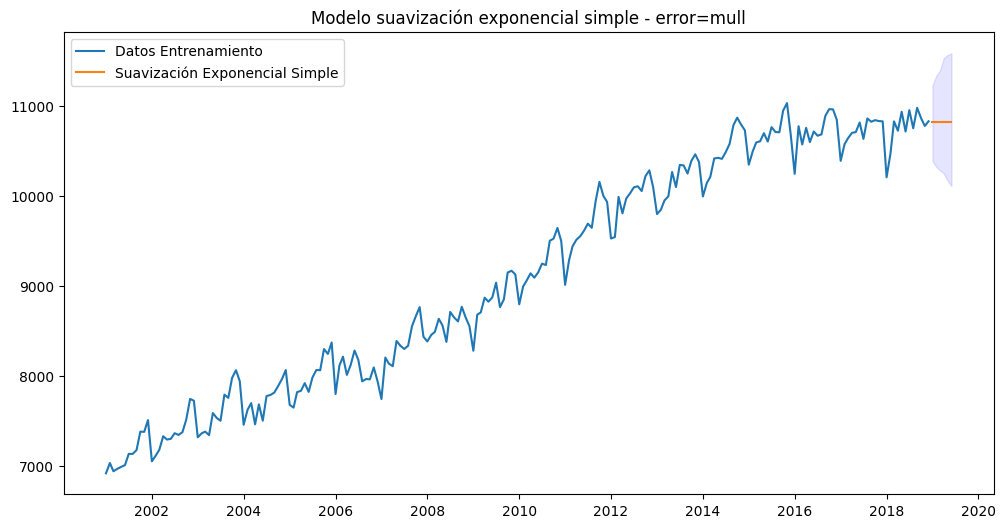

In [21]:
preds_mul = results["mul"]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_mul['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds_mul.index ,preds_mul['lower_95'], preds_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title("Modelo suavización exponencial simple - error=mull")
plt.show()

## **4.3 Suavizacion Exponencial Lineal (Holt)**

In [22]:
errors = ["add", "mul"]
trend = ["add", "mul", None]

results_holt = {}

for error_type in errors:
  for trend_type in trend:
    ets_model = ETSModel(endog=train_td['Ocupados'], error=error_type, trend=trend_type)
    ets_result = ets_model.fit()

    point_forecast = ets_result.forecast(6)

    ci = ets_result.get_prediction(start=point_forecast.index[0], end=point_forecast.index[-1])

    conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
    limits = ci.predicted_mean

    preds_holt = pd.concat([limits, conf_forecast], axis=1)
    preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']

    print(f"Resultados para error={error_type}, trend={trend_type}:")
    print("-"*40)
    print(preds_holt)
    print("-"*40)
    print(f"Alpha (Nivel): {ets_result.alpha}")
    if trend_type is not None:
            print(f"Beta (Tendencia): {ets_result.beta}")
    print("-"*40)
    rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
    print(f"RMSE_HOLT: {rmse_holt}")
    print("-"*40)


    key = f"error_{error_type}, trend_{trend_type}"
    results_holt[key] = preds_holt

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10862.758893  10510.444660  11215.073126
2019-02-01    10879.826701  10472.720445  11286.932958
2019-03-01    10896.894510  10440.526909  11353.262110
2019-04-01    10913.962318  10412.222196  11415.702440
2019-05-01    10931.030127  10386.823383  11475.236870
2019-06-01    10948.097935  10363.687927  11532.507943
----------------------------------------
Alpha (Nivel): 0.5725831823098677
Beta (Tendencia): 0.006404915956342309
----------------------------------------
RMSE_HOLT: 296.15524441244435
----------------------------------------
Resultados para error=add, trend=mul:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10870.463304  10536.693701  11192.210703
2019-02-01    10890.832235  10499.229638  11276.518809
2019-03-01    10911.239333  10480.984681  11361.816352
2019-04-01 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=None:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10830.738569  10476.461345  11185.015792
2019-02-01    10830.738569  10411.310139  11250.166999
2019-03-01    10830.738569  10354.999076  11306.478061
2019-04-01    10830.738569  10304.681612  11356.795526
2019-05-01    10830.738569  10258.773728  11402.703409
2019-06-01    10830.738569  10216.286263  11445.190874
----------------------------------------
Alpha (Nivel): 0.6337323614899885
----------------------------------------
RMSE_HOLT: 253.63725759469287
----------------------------------------
Resultados para error=mul, trend=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10863.040811  10440.414836  11303.838080
2019-02-01    10880.579474  10406.511678  11371.492057
2019-03-01    10898.118137  10337.252278  11419.472657
2019-04-01    10915.656801  10289.648826  11517.9

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


* **NOTA:**

El modelo de suavización exponencial lineal (Holt) con error=mul y trend=None, fue el de mejor RMSE con 253.63268060657933. En este caso el α estimado es 0.6339942849598692.

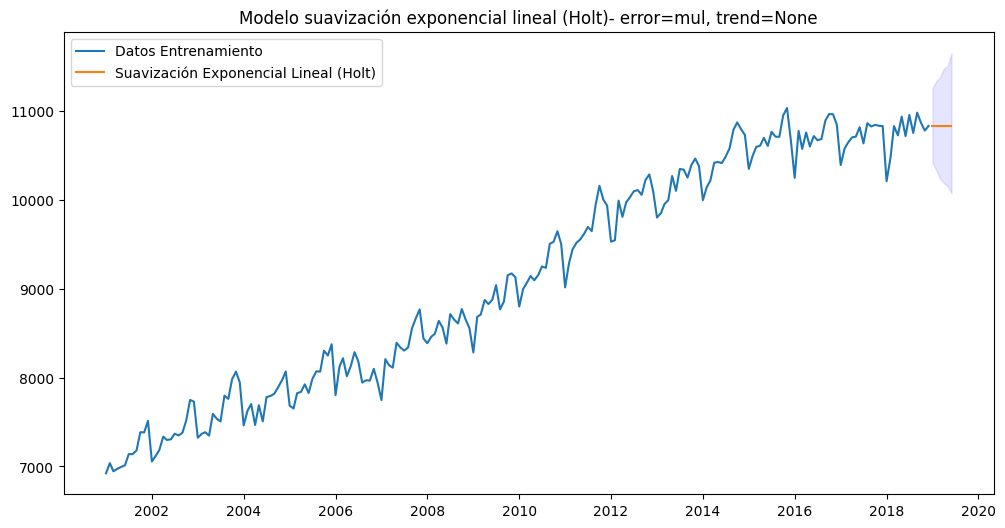

In [23]:
preds_mejor = results_holt['error_mul, trend_None']

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_mejor['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_mejor.index ,preds_mejor['lower_95'], preds_mejor['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title('Modelo suavización exponencial lineal (Holt)- error=mul, trend=None')
plt.show()

## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [24]:
errors = ["add", "mul"]
trend = ["add", "mul", None]
seasonal = ["add", "mul"]

results_HW = {}

for error_type in errors:
  for trend_type in trend:
    for seasonal_type in seasonal:
      # Skip multiplicative seasonal model if data contains non-positive values
      if seasonal_type == "mul" and (train_td['Ocupados'] <= 0).any():
          print(f"Skipping model with error={error_type}, trend={trend_type}, seasonal={seasonal_type} due to non-positive data.")
          continue

      ets_model = ETSModel(endog=train_td['Ocupados'], error=error_type, trend=trend_type, seasonal=seasonal_type)
      ets_result = ets_model.fit()

      point_forecast = ets_result.forecast(6)

      ci = ets_result.get_prediction(start=point_forecast.index[0], end=point_forecast.index[-1])

      conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
      limits = ci.predicted_mean

      preds_HW = pd.concat([limits, conf_forecast], axis=1)
      preds_HW.columns = ['Point_forecast', 'lower_95', 'upper_95']

      print(f"Resultados para error={error_type}, trend={trend_type}, seasonal={seasonal_type}:")
      print("-"*40)
      print(preds_HW)
      print("-"*40)
      print(f"Alpha (Nivel): {ets_result.alpha}")
      if trend_type is not None:
            print(f"Beta (Tendencia): {ets_result.beta}")
      print(f"Gamma (Estacionalidad): {ets_result.gamma}")
      print("-"*40)
      rmse_HW = np.sqrt(mean_squared_error(test_td,preds_HW['Point_forecast']))
      print(f"RMSE_HW: {rmse_HW}")
      print("-"*40)


      key = f"error_{error_type}, trend_{trend_type}, seasonal_{seasonal_type}"
      results_HW[key] = preds_HW

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=add, seasonal=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10349.094194  10090.610132  10607.578256
2019-02-01    10624.690071  10350.551423  10898.828720
2019-03-01    10770.101783  10481.152558  11059.051007
2019-04-01    10786.274106  10483.234541  11089.313670
2019-05-01    10870.829275  10554.323400  11187.335150
2019-06-01    10828.784921  10499.360228  11158.209614
----------------------------------------
Alpha (Nivel): 0.35322663405671384
Beta (Tendencia): 3.5322663405671385e-05
Gamma (Estacionalidad): 0.29694595046559796
----------------------------------------
RMSE_HW: 74.44457717563775
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=add, seasonal=mul:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10369.524042  10143.651908  10605.754242
2019-02-01    10586.718230  10340.580203  10823.524603
2019-03-01    10688.561499  10395.875509  10958.862510
2019-04-01    10716.214248  10406.426056  11011.880738
2019-05-01    10803.155956  10465.641200  11150.316477
2019-06-01    10776.765317  10384.250769  11137.071090
----------------------------------------
Alpha (Nivel): 0.5243386266245855
Beta (Tendencia): 0.0018054725128846055
Gamma (Estacionalidad): 4.756613733754145e-05
----------------------------------------
RMSE_HW: 59.63433929940899
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=mul, seasonal=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10332.377260  10014.049218  10642.144067
2019-02-01    10616.453614  10295.308382  10910.471727
2019-03-01    10769.121111  10414.385957  11122.096448
2019-04-01    10770.412388  10407.209238  11141.241343
2019-05-01    10863.327435  10481.891441  11248.168000
2019-06-01    10815.930239  10408.375023  11211.480812
----------------------------------------
Alpha (Nivel): 0.4075988183407854
Beta (Tendencia): 4.075988183407854e-05
Gamma (Estacionalidad): 0.334126580162259
----------------------------------------
RMSE_HW: 66.49505276373334
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=mul, seasonal=mul:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10367.442166  10144.887837  10599.947723
2019-02-01    10585.346764  10333.117615  10850.124462
2019-03-01    10687.324428  10408.642836  10963.761073
2019-04-01    10715.038053  10427.187762  11003.744939
2019-05-01    10802.109635  10459.488420  11122.083943
2019-06-01    10775.743722  10458.990634  11128.250510
----------------------------------------
Alpha (Nivel): 0.525353314736116
Beta (Tendencia): 5.2535331473611604e-05
Gamma (Estacionalidad): 4.74646685263884e-05
----------------------------------------
RMSE_HW: 59.423908846598934
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=None, seasonal=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10387.975340  10129.551854  10646.398825
2019-02-01    10636.973661  10339.947821  10933.999501
2019-03-01    10733.725728  10402.567153  11064.884302
2019-04-01    10731.978012  10369.890104  11094.065921
2019-05-01    10768.532056  10377.956448  11159.107664
2019-06-01    10714.098112  10296.975879  11131.220345
----------------------------------------
Alpha (Nivel): 0.566626838213093
Gamma (Estacionalidad): 0.13511920226520244
----------------------------------------
RMSE_HW: 83.95091022389738
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=add, trend=None, seasonal=mul:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10325.781740  10086.665520  10557.726587
2019-02-01    10527.749200  10281.146308  10806.331819
2019-03-01    10611.310498  10305.977377  10912.250603
2019-04-01    10620.935091  10277.926633  10972.012585
2019-05-01    10689.617917  10307.150715  11075.142729
2019-06-01    10645.660972  10273.793974  11053.698781
----------------------------------------
Alpha (Nivel): 0.5975179083987354
Gamma (Estacionalidad): 4.024820916012646e-05
----------------------------------------
RMSE_HW: 115.22874802708579
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=mul, trend=add, seasonal=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10342.786260  10040.773765  10638.644104
2019-02-01    10622.471714  10280.235525  10940.854095
2019-03-01    10773.200410  10439.943230  11125.315821
2019-04-01    10782.751822  10420.700119  11157.527321
2019-05-01    10872.035616  10493.440796  11270.972640
2019-06-01    10827.059786  10405.470742  11242.367120
----------------------------------------
Alpha (Nivel): 0.3642585423205111
Beta (Tendencia): 3.642585423205111e-05
Gamma (Estacionalidad): 0.3213342754086707
----------------------------------------
RMSE_HW: 72.76293463513997
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=mul, trend=add, seasonal=mul:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10367.819610  10103.673376  10633.174577
2019-02-01    10581.945476  10259.867145  10907.355967
2019-03-01    10674.057264  10330.132047  11021.281050
2019-04-01    10694.673347  10327.853390  11085.304443
2019-05-01    10790.195242  10366.065646  11213.318129
2019-06-01    10760.456573  10356.335858  11192.682779
----------------------------------------
Alpha (Nivel): 0.5594430987525479
Beta (Tendencia): 0.0006632424119580153
Gamma (Estacionalidad): 4.405569012474521e-05
----------------------------------------
RMSE_HW: 61.98850871447056
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=mul, trend=mul, seasonal=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10322.593021   9955.595881  10688.584669
2019-02-01    10616.657040  10216.605511  11050.520717
2019-03-01    10777.630100  10307.162716  11221.866354
2019-04-01    10771.713027  10294.059449  11260.407866
2019-05-01    10874.763136  10345.028908  11429.014710
2019-06-01    10826.842876  10241.560050  11430.578460
----------------------------------------
Alpha (Nivel): 0.4580421083167499
Beta (Tendencia): 4.580421083167499e-05
Gamma (Estacionalidad): 0.35259115823599974
----------------------------------------
RMSE_HW: 67.79278849047284
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=mul, trend=mul, seasonal=mul:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10365.867450  10111.401904  10629.116532
2019-02-01    10580.201547  10267.314537  10905.439610
2019-03-01    10671.929391  10343.019958  11018.429737
2019-04-01    10692.229388  10323.777416  11083.504903
2019-05-01    10787.433531  10387.296468  11191.477331
2019-06-01    10757.340525  10343.871450  11201.031951
----------------------------------------
Alpha (Nivel): 0.5559065347683159
Beta (Tendencia): 5.559065347683159e-05
Gamma (Estacionalidad): 4.440934652316842e-05
----------------------------------------
RMSE_HW: 62.62627408858487
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=mul, trend=None, seasonal=add:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10266.104680   9933.447181  10594.209359
2019-02-01    10540.017359  10172.574844  10918.307061
2019-03-01    10678.015036  10269.020149  11091.060879
2019-04-01    10664.483798  10236.538001  11074.909227
2019-05-01    10750.900502  10292.050252  11236.741495
2019-06-01    10690.576002  10148.343973  11148.110963
----------------------------------------
Alpha (Nivel): 0.4945056220705801
Gamma (Estacionalidad): 0.32569149311690604
----------------------------------------
RMSE_HW: 80.82689925276753
----------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para error=mul, trend=None, seasonal=mul:
----------------------------------------
            Point_forecast      lower_95      upper_95
2019-01-01    10324.802619  10056.537590  10595.768476
2019-02-01    10522.814838  10190.004430  10838.009119
2019-03-01    10595.192695  10205.097866  10949.137809
2019-04-01    10596.271288  10180.166013  10995.695158
2019-05-01    10671.633689  10215.666885  11087.000000
2019-06-01    10622.718774  10134.317396  11093.845194
----------------------------------------
Alpha (Nivel): 0.6251225694003489
Gamma (Estacionalidad): 3.748774305996511e-05
----------------------------------------
RMSE_HW: 129.5968268172169
----------------------------------------


* **NOTA:**

El modelo de suavización exponencial lineal (Holt) con error=ad, trend=mul y seasonal=mul, fue el de mejor RMSE con 59.423908846598934. En este caso el α estimado es 0.525353314736116, el β estimado es 5.2535331473611604e-05 y el Gamma es 4.74646685263884e-05.

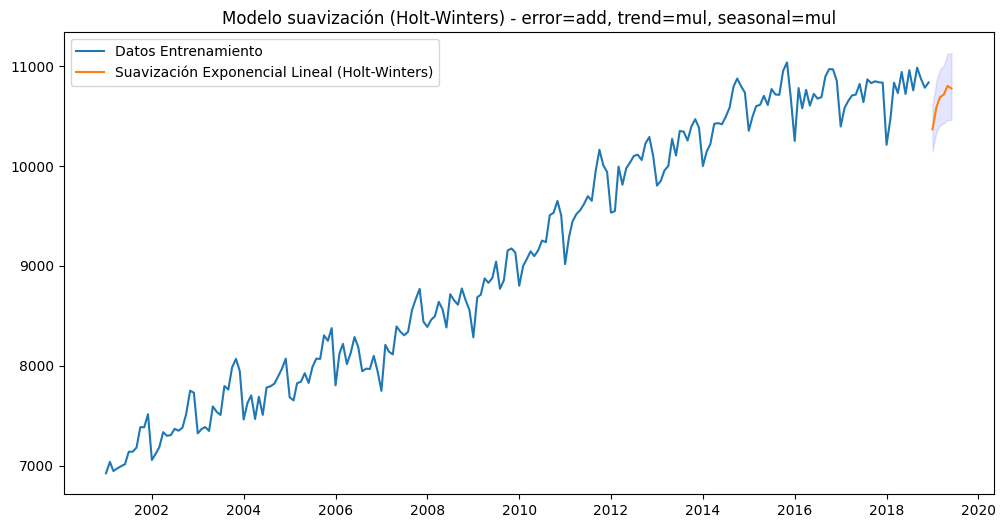

In [25]:
mejor_hw = results_HW['error_add, trend_mul, seasonal_mul']

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(mejor_hw['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters)")
plt.fill_between(mejor_hw.index ,mejor_hw['lower_95'], mejor_hw['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title('Modelo suavización (Holt-Winters) - error=add, trend=mul, seasonal=mul')
plt.show()

## **5. Comparación de modelos**

In [26]:
Resultados_RMSE = {
    'Promedio Móvil (w=2)': rmse_ma_2,
    'Promedio Móvil (w=3)': rmse_ma_3,
    'Promedio Móvil (w=4)': rmse_ma_4,
    'Promedio Móvil (w=5)': rmse_ma_5,
    'Promedio Móvil (w=6)': rmse_ma_6,
    'Suavización Exponencial Simple (additive)': np.sqrt(mean_squared_error(test_td, results['add']['Point_forecast'])),
    'Suavización Exponencial Simple (multiplicative)': np.sqrt(mean_squared_error(test_td, results['mul']['Point_forecast'])),
    'Holt (error=add, trend=add)': np.sqrt(mean_squared_error(test_td, results_holt['error_add, trend_add']['Point_forecast'])),
    'Holt (error=add, trend=mul)': np.sqrt(mean_squared_error(test_td, results_holt['error_add, trend_mul']['Point_forecast'])),
    'Holt (error=mul, trend=add)': np.sqrt(mean_squared_error(test_td, results_holt['error_mul, trend_add']['Point_forecast'])),
    'Holt (error=mul, trend=mul)': np.sqrt(mean_squared_error(test_td, results_holt['error_mul, trend_mul']['Point_forecast'])),
    'Holt-Winters (error=add, trend=add, seasonal=add)': np.sqrt(mean_squared_error(test_td, results_HW['error_add, trend_add, seasonal_add']['Point_forecast'])),
    'Holt-Winters (error=add, trend=add, seasonal=mul)': np.sqrt(mean_squared_error(test_td, results_HW['error_add, trend_add, seasonal_mul']['Point_forecast'])),
    'Holt-Winters (error=add, trend=mul, seasonal=add)': np.sqrt(mean_squared_error(test_td, results_HW['error_add, trend_mul, seasonal_add']['Point_forecast'])),
    'Holt-Winters (error=add, trend=mul, seasonal=mul)': np.sqrt(mean_squared_error(test_td, results_HW['error_add, trend_mul, seasonal_mul']['Point_forecast'])),
    'Holt-Winters (error=mul, trend=add, seasonal=add)': np.sqrt(mean_squared_error(test_td, results_HW['error_mul, trend_add, seasonal_add']['Point_forecast'])),
    'Holt-Winters (error=mul, trend=add, seasonal=mul)': np.sqrt(mean_squared_error(test_td, results_HW['error_mul, trend_add, seasonal_mul']['Point_forecast'])),
    'Holt-Winters (error=mul, trend=mul, seasonal=add)': np.sqrt(mean_squared_error(test_td, results_HW['error_mul, trend_mul, seasonal_add']['Point_forecast'])),
    'Holt-Winters (error=mul, trend=mul, seasonal=mul)': np.sqrt(mean_squared_error(test_td, results_HW['error_mul, trend_mul, seasonal_mul']['Point_forecast'])),
    'Holt-Winters (error=add, trend=None, seasonal=add)': np.sqrt(mean_squared_error(test_td, results_HW['error_add, trend_None, seasonal_add']['Point_forecast'])),
    'Holt-Winters (error=add, trend=None, seasonal=mul)': np.sqrt(mean_squared_error(test_td, results_HW['error_add, trend_None, seasonal_mul']['Point_forecast'])),
    'Holt-Winters (error=mul, trend=None, seasonal=add)': np.sqrt(mean_squared_error(test_td, results_HW['error_mul, trend_None, seasonal_add']['Point_forecast'])),
    'Holt-Winters (error=mul, trend=None, seasonal=mul)': np.sqrt(mean_squared_error(test_td, results_HW['error_mul, trend_None, seasonal_mul']['Point_forecast'])),
    'Holt (error=add, trend=None)': np.sqrt(mean_squared_error(test_td, results_holt['error_add, trend_None']['Point_forecast'])),
    'Holt (error=mul, trend=None)': np.sqrt(mean_squared_error(test_td, results_holt['error_mul, trend_None']['Point_forecast'])),

}

# Create a DataFrame from the dictionary

Comparativo_RMSE = pd.DataFrame.from_dict(Resultados_RMSE, orient='index', columns=['RMSE'])

# Sort the DataFrame by RMSE
Comparativo_RMSE = Comparativo_RMSE.sort_values(by='RMSE')

# Add a 'Modelo' column from the index
Comparativo_RMSE.insert(0, 'Modelo', Comparativo_RMSE.index)

# Reset the index to remove the original index
Comparativo_RMSE = Comparativo_RMSE.reset_index(drop=True)

print("\nTabla comparativa de RMSE de los modelos:")
display(Comparativo_RMSE)


Tabla comparativa de RMSE de los modelos:


,Modelo,RMSE
0,"Holt-Winters (error=add, trend=mul, seasonal=mul)",59.423909
1,"Holt-Winters (error=add, trend=add, seasonal=mul)",59.634339
2,"Holt-Winters (error=mul, trend=add, seasonal=mul)",61.988509
3,"Holt-Winters (error=mul, trend=mul, seasonal=mul)",62.626274
4,"Holt-Winters (error=add, trend=mul, seasonal=add)",66.495053
5,"Holt-Winters (error=mul, trend=mul, seasonal=add)",67.792788
6,"Holt-Winters (error=mul, trend=add, seasonal=add)",72.762935
7,"Holt-Winters (error=add, trend=add, seasonal=add)",74.444577
8,"Holt-Winters (error=mul, trend=None, seasonal=...",80.826899
9,"Holt-Winters (error=add, trend=None, seasonal=...",83.950910


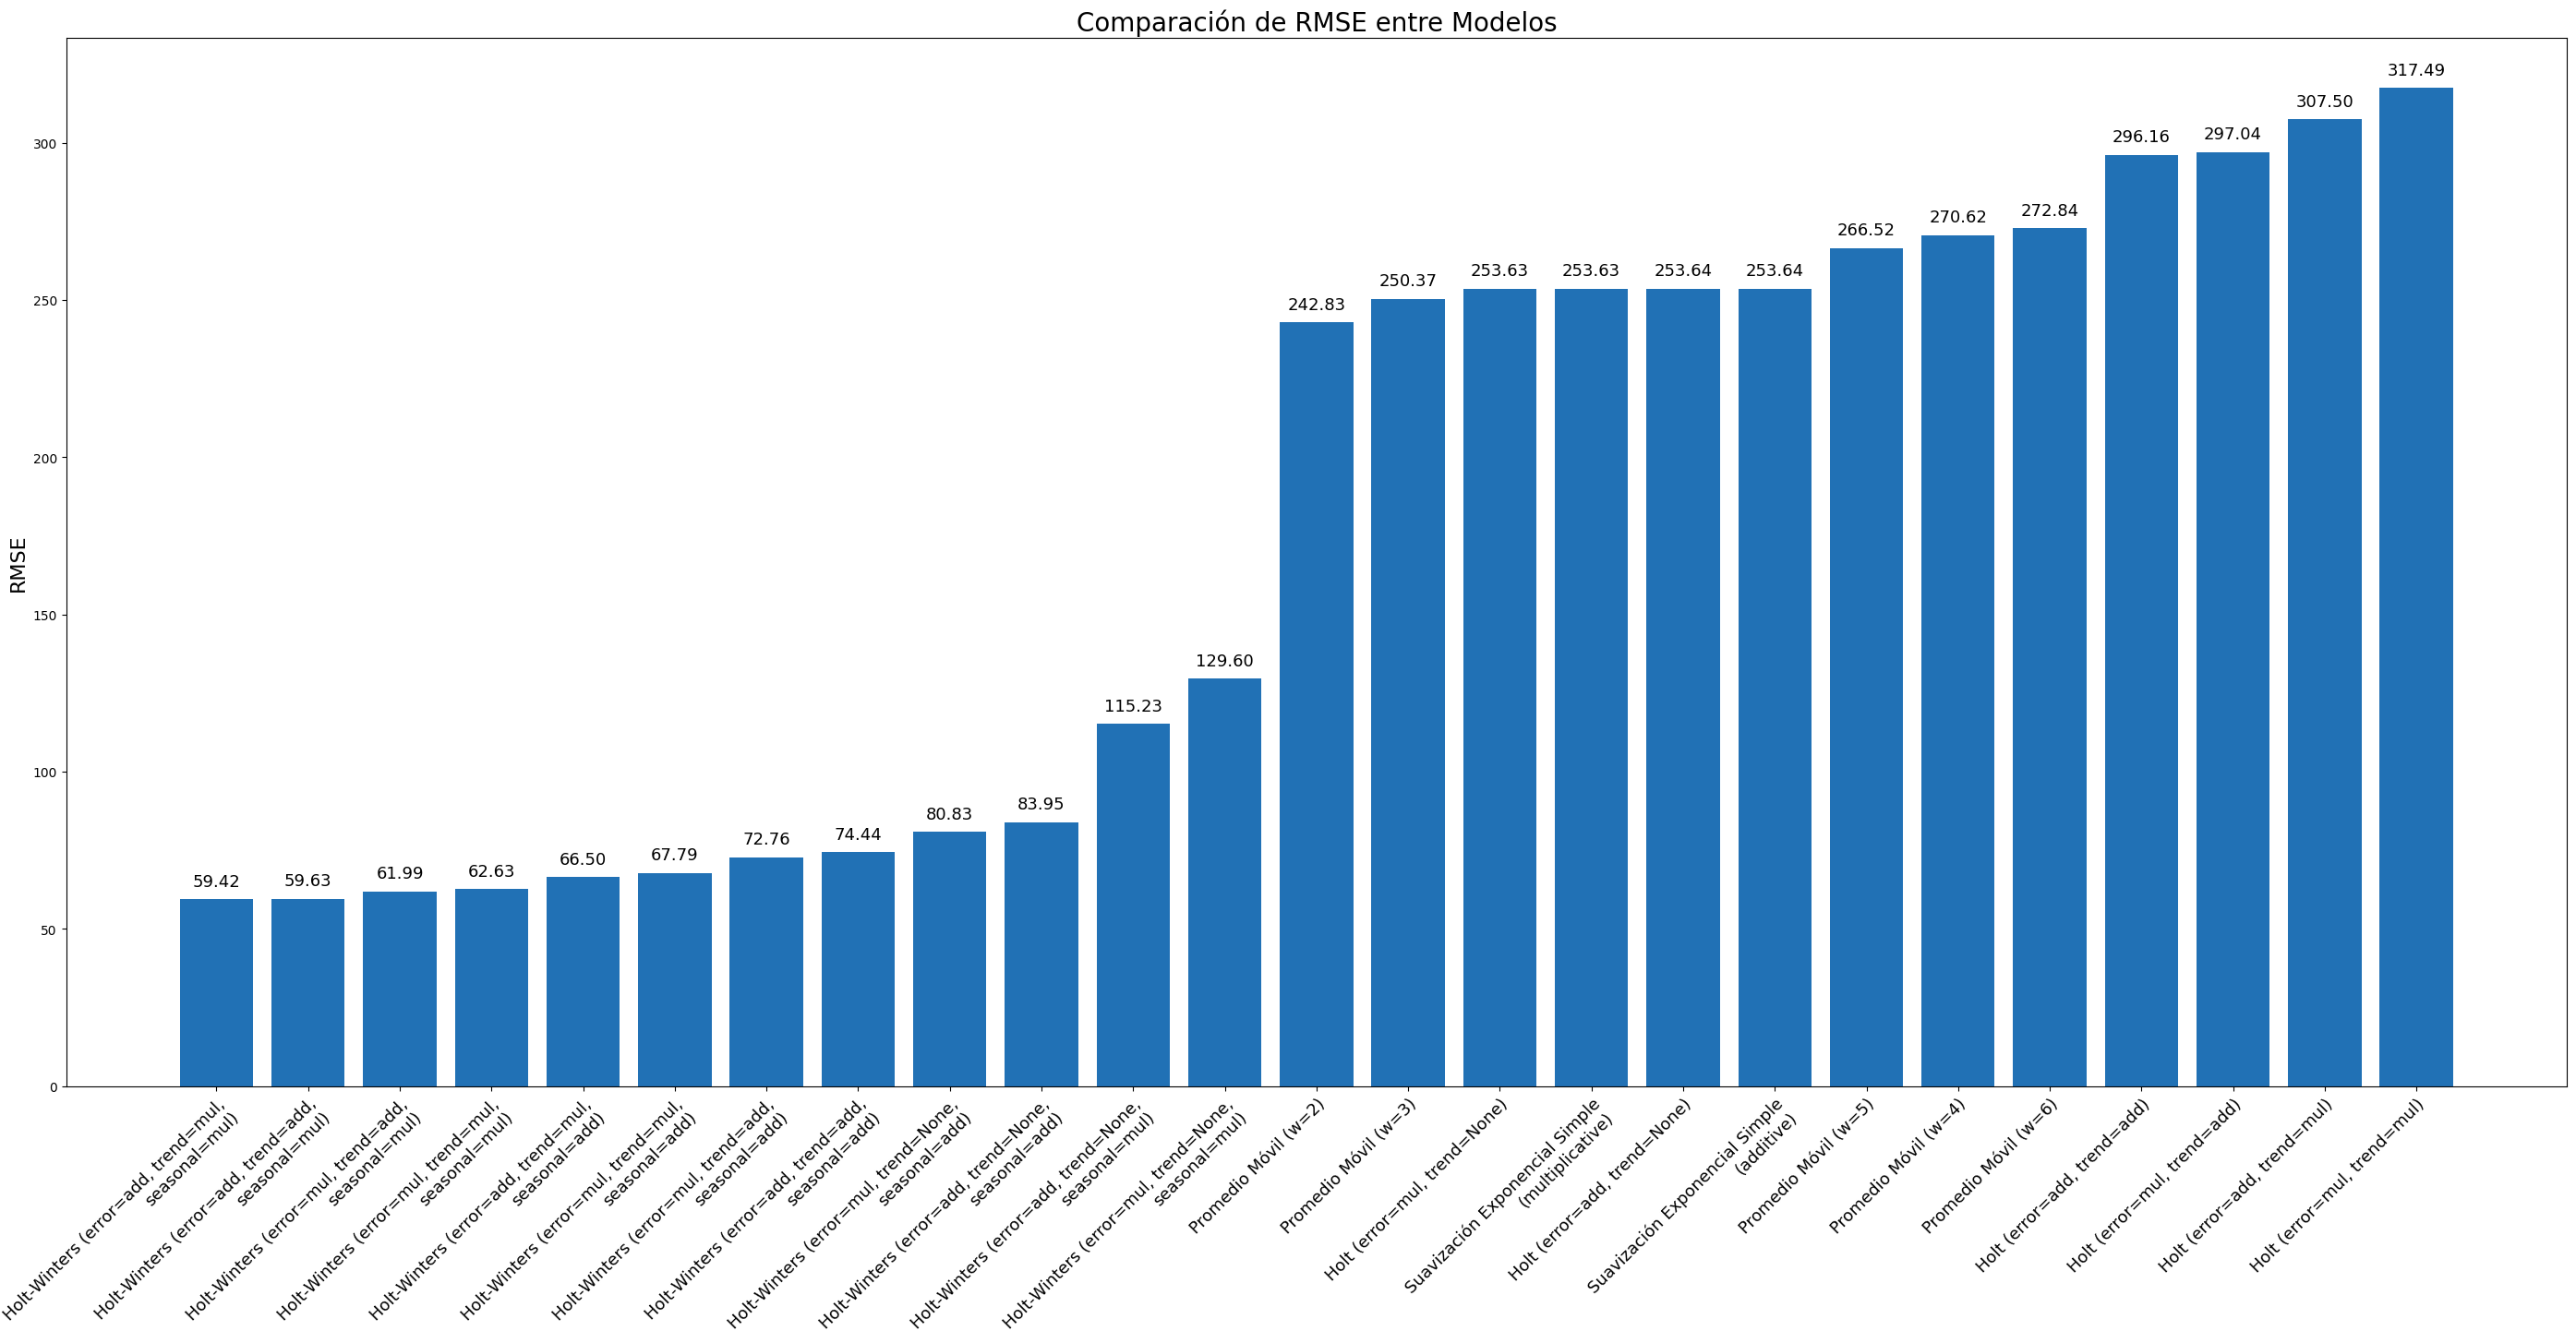

In [27]:
plt.figure(figsize=(28, 14))
bars = plt.bar(Comparativo_RMSE['Modelo'], Comparativo_RMSE['RMSE'], color='#2171b5')

# Mejor rotación y alineación, fuente grande
plt.xticks(rotation=45, ha='right', fontsize=13, wrap=True)

plt.xlabel("Modelo", fontsize=16)
plt.ylabel("RMSE", fontsize=16)
plt.title("Comparación de RMSE entre Modelos", fontsize=20)

# Etiquetas numéricas encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3,
             f'{yval:.2f}', ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()


## **6. Suavización Exponencial All Data**

### Se ajusta el modelo con el train y se observan los hiperparametros obtenidos en la optimización

In [28]:
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend="mul",seasonal="mul")
ets_result = ets_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
## Se obtienen los hiperparametros

print(f"Alpha (Nivel): {ets_result.alpha}")
print(f"Beta (Tendencia): {ets_result.beta}")
print(f"Gamma (Estacionalidad): {ets_result.gamma}")
print(f"Param names: {ets_result.param_names}")

Alpha (Nivel): 0.525353314736116
Beta (Tendencia): 5.2535331473611604e-05
Gamma (Estacionalidad): 4.74646685263884e-05
Param names: ['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']


In [30]:
## Ahora se ajusta el modelo final con todos los datos

final_model = ETSModel(endog=data['Ocupados'],error="add",trend="add",seasonal="add")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.525353314736116,'smoothing_trend': 5.2535331473611604e-05,'smoothing_seasonal':4.74646685263884e-05})

print(final_model_fit.alpha)
print(final_model_fit.beta)
print(final_model_fit.gamma)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


0.525353314736116
5.2535331473611604e-05
4.74646685263884e-05


El método fit_constrained fuerza el modelo a usar exactamente esos valores para sus parámetros de actualización interna en los filtros de suavización exponencial, manteniendo fija la “velocidad” con la que se ajustan nivel, tendencia y estacionalidad en cada nuevo periodo calculado

In [31]:
point_forecast=final_model_fit.forecast(6)

ci = final_model_fit.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2019-07-01    10899.953426  10678.776574  11121.130277
2019-08-01    10891.680140  10641.833370  11141.526910
2019-09-01    10968.047336  10692.492771  11243.601901
2019-10-01    11095.142406  10796.077314  11394.207497
2019-11-01    11121.890264  10801.028548  11442.751980
2019-12-01    11045.568148  10704.295157  11386.841139


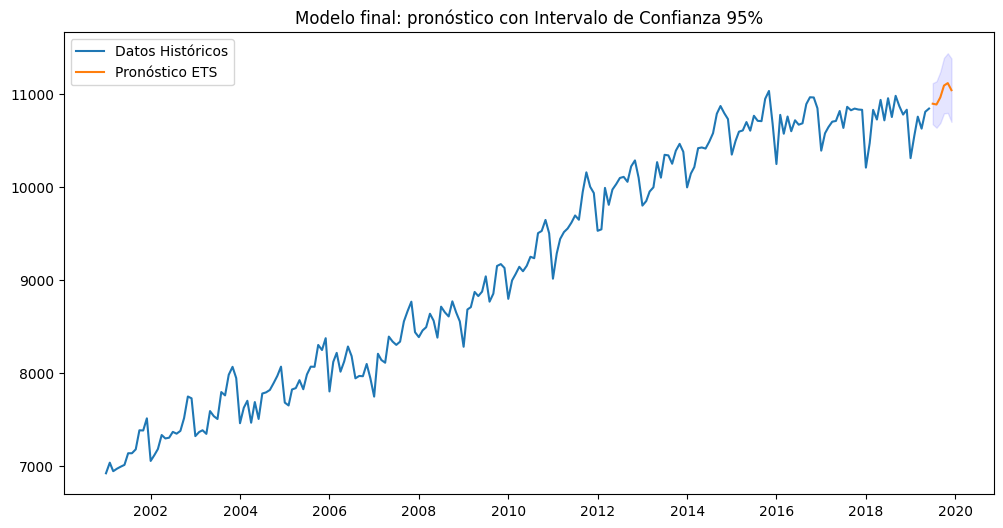

In [32]:
fig = plt.figure(figsize=(12, 6))

# Serie histórica completa de Ocupados
plt.plot(data.index, data['Ocupados'], label="Datos Históricos")

# Pronóstico puntual (6 meses)
plt.plot(preds_hw_add.index, preds_hw_add['Point_forecast'], label="Pronóstico ETS")

# Intervalo de confianza 95%
plt.fill_between(preds_hw_add.index,
                 preds_hw_add['lower_95'],
                 preds_hw_add['upper_95'],
                 color='blue', alpha=0.1)

plt.legend()
plt.title('Modelo final: pronóstico con Intervalo de Confianza 95%')
plt.show()